# Simulation of wagering to unlock bonuses

In [27]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [562]:
# params
initial_wager = 10

bonus = 20
wagering_requirement = 400
rtp = 0.9734
stakes = 0.5
n_simulations = 10000

free_spins = 30
free_spins_value = 0.1
free_spins_wagering = 10

In [563]:
# simulations
n_spins = int(wagering_requirement/stakes)
p_win = rtp/2

outcomes = []
cumulative_winnings_df = []
i = 0
for s in tqdm_notebook(range(n_simulations)):
    wins_array = np.random.binomial(1, p_win, n_spins)
    winnings_array = wins_array*stakes*2 - stakes
    cumulative_winnings_array = bonus + winnings_array.cumsum()
    bust = sum(cumulative_winnings_array<=0)>0
    if bust:
        outcomes.append(0)
    else:
        outcomes.append(cumulative_winnings_array[-1])
    
    if i < 100:
        cumulative_winnings_df.append(cumulative_winnings_array)
    i += 1

cumulative_winnings_df = pd.DataFrame(cumulative_winnings_df).T

Initial wager EL: £-0.27
Bonus amount EV:  £10.9
Bonus Q 50%:      £9.0
Bonus Q 75%:      £19.0
Bonus Q 90%:      £27.0
Bonus P(bust):    0.38
Free spins EV:    £2.92
Total EV:         £13.56


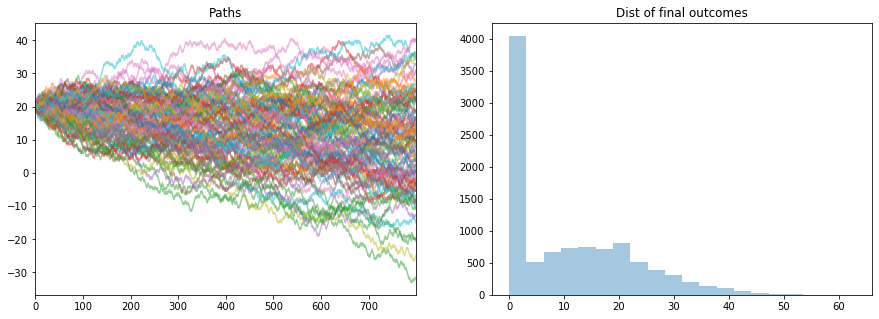

In [564]:
print(f'Initial wager EL: £{round(initial_wager*(rtp-1),2)}')
print(f'Bonus amount EV:  £{round(np.mean(outcomes),2)}')
print(f'Bonus Q 50%:      £{round(np.quantile(outcomes, 0.5),2)}')
print(f'Bonus Q 75%:      £{round(np.quantile(outcomes, 0.75),2)}')
print(f'Bonus Q 90%:      £{round(np.quantile(outcomes, 0.9),2)}')
print(f'Bonus P(bust):    {round(sum(np.array(outcomes)==0)/len(outcomes),2)}')
print(f'Free spins EV:    £{round(free_spins*free_spins_value*rtp, 2)}')
print(f'Total EV:         £{round(initial_wager*(rtp-1)+np.mean(outcomes)+free_spins*free_spins_value*rtp,2)}')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cumulative_winnings_df.iloc[:,:100].plot(kind='line', ax=ax[0], legend=False, alpha=0.5, title='Paths')
sns.distplot(outcomes, ax=ax[1], kde=False, bins=20).set_title('Dist of final outcomes')
plt.show()

In [559]:
check_outcomes = [
    0 if c else o for c, o in zip((cumulative_winnings_df<=0).sum(axis=0)>0, cumulative_winnings_df.iloc[-1,:])]

In [560]:
np.mean(check_outcomes)

10.04

In [561]:
sum(np.array(check_outcomes)==0)/len(check_outcomes)

0.57

#### Get distribution for n similar bonuses

In [488]:
n_bonuses = 10
n_samples = 1000
agg_outcomes = [sum(np.random.choice(outcomes, n_bonuses)) for i in tqdm_notebook(range(n_samples))]

Text(0.5, 1.0, 'Dist of final outcomes')

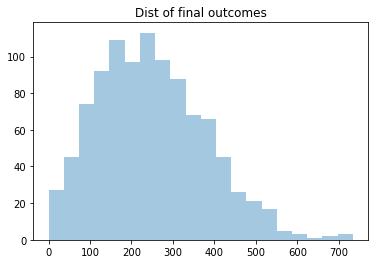

In [489]:
sns.distplot(agg_outcomes, kde=False, bins=20).set_title('Dist of final outcomes')

#### Quick manual check why bigger stakes give better EV when p(win) < 0.5

In [502]:
# with 2 rounds
wager = 50 # also starting balance
p_win = 0.4
p_lose = 1 - p_win
outcome_11 = wager + wager + wager
outcome_10 = wager + wager - wager
outcome_01 = wager - wager + wager
outcome_00 = wager - wager - wager
p_11 = p_win * p_win
p_10 = p_win * p_lose
p_01 = p_lose * p_win
p_00 = p_lose * p_lose

print(f'After first spin, EV0: {wager * p_win - wager * p_lose}')
print(f'After first spin, EV1: {2*wager + wager * p_win - wager * p_lose}')
print(f'Normal EV: {outcome_11 * p_11 + outcome_10 * p_10 + outcome_01 * p_01 + outcome_00 * p_00}')
print(f'EV with stops at 0: {outcome_11 * p_11 + outcome_10 * p_10 + 0 * p_01 + 0 * p_00}')

After first spin, EV0: -10.0
After first spin, EV1: 90.0
Normal EV: 30.0
EV with stops at 0: 36.0


#### What about strategy of always betting half of what is left?